<a href="https://colab.research.google.com/github/polis-community/red-dwarf/blob/main/docs/notebooks/polis-implementation-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --no-cache-dir git+https://github.com/polis-community/red-dwarf.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 210.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 185.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 135.6 MB/s eta 0:00:00


In [2]:
from reddwarf.polis import PolisClient
import json

# Topic: What were the most significant developments in tech and politics in 2018?
# 5 groups, 65 ptpts (56 grouped), 43 comments (open)
REPORT_ID="r6bpmcmizi2kyvhzkhfr7"

print(f"Loading data from https://pol.is/report/{REPORT_ID}")

# We'll use the old class-based client to simple load vote data.
client = PolisClient()
client.load_data(polis_id=REPORT_ID)
votes = client.data_loader.votes_data

# Show what our raw vote data looks like:
print(json.dumps(votes[0], indent=2))

# Show what our raw statement data looks like:
statements = client.data_loader.comments_data
print(json.dumps(statements[0], indent=2))

# We need this for a little helper later.
math_data = client.data_loader.math_data

Loading data from https://pol.is/report/r6bpmcmizi2kyvhzkhfr7
{
  "participant_id": 0,
  "statement_id": 0,
  "vote": 0,
  "weight_x_32767": 0,
  "modified": 1714782753431.0,
  "conversation_id": "4cvkai2ctw",
  "datetime": null
}
{
  "txt": "The prominent display of divisive issues is concerning as politicians like to find wedge issues and exploit them.",
  "statement_id": 1,
  "created": "2024-05-02T01:27:12.171000Z",
  "tweet_id": null,
  "quote_src_url": null,
  "is_seed": true,
  "is_meta": false,
  "lang": "en",
  "participant_id": 0,
  "velocity": 1,
  "moderated": 1,
  "active": true,
  "agree_count": 4,
  "disagree_count": 5,
  "pass_count": 6,
  "count": 15,
  "conversation_id": "4cvkai2ctw",
  "datetime": null
}


math_data['mod-out']=[33, 11]
mod_out_statement_ids=[33, 11]
init_cluster_center_guesses=[[-0.8815183295636166, -0.9368208225065185], [-2.240317342307938, 1.235331645814958], [1.8225543682165275, 0.8264564422323741]]
Calculating convex hulls around clusters...
Hull 0, bounding 3 points
Hull 1, bounding 8 points
Hull 2, bounding 8 points


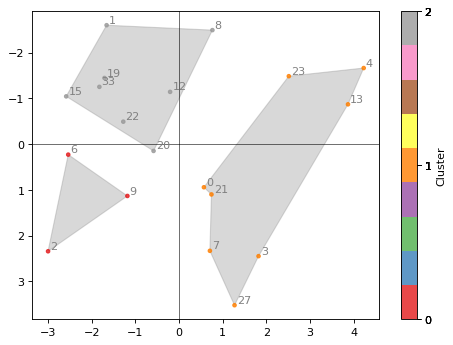

In [71]:
# Now we use out custom polis implementation to recreate the Polis calculations.
from reddwarf.implementations.polis import run_clustering

# In this conversation, any -1 is moderated out.
mod_out_statement_ids = [st["statement_id"] for st in statements if st["moderated"] in [-1]]
print(f"{math_data['mod-out']=}")
print(f"{mod_out_statement_ids=}")

# We can run this from scratch, but kmeans is non-deterministic and might find slightly different clusters
# or even different k-values (number of groups) if the silhouette scores if finds are better.
# To show how to reproduce Polis results, we'll set init guess coordinates that we know polis platform got:
init_cluster_center_guesses = [group["center"] for group in math_data["group-clusters"]]
init_cluster_center_guesses = [[xy[0], xy[1]] for xy in init_cluster_center_guesses]
print(f"{init_cluster_center_guesses=}")

# Now with those guessed cluster centers seeded, we'll run the whole calculation from raw vote data.
result = run_clustering(
  votes=votes,
  mod_out_statement_ids=mod_out_statement_ids,
  force_group_count=3
)

# print(result.projected_participants.head(10))

from reddwarf.data_presenter import generate_figure

cluster_labels = result.projected_participants["cluster_id"].values
# print(cluster_labels)

generate_figure(coord_dataframe=result.projected_participants, labels=cluster_labels)